# WireScanner before/after Deconvolution

In this notebook we compare the WS measurements for an **LHC25-type beam** with the default parameters and application used in 2016 and the proposed changes in 2017, i.e. measured dispersion and full deconvolution assuming the profile Gaussian for the betatronic component.

Input needed:
* WS output file from FESA class
* Tomogram for each measurement (so far acquired with an independent application and synchronized by hand)

The idea is to dump the content of the analysis into a pickle files to be later compared with the output coming from ExtractEmittancePSBSemGrids.ipynb


In [1]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
#you can add it in a the a configuration script to run at the start of SWAN e.g.:
# export PYTHONPATH="$PYTHONPATH:/eos/user/s/sterbini/MD_ANALYSIS/public"
from myToolbox import *

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-327.36.3.el7.x86_64-x86_64-with-redhat-6.7-Carbon
Your folder is /eos/user/d/digiovan/MD_ANALYSIS/2016/MD74
Your IP is 172.17.0.7
2017-02-21 16:54:56


In [2]:
# GP's toolbox
sys.path.append('/eos/user/d/digiovan/MD_ANALYSIS/public/')
from gpToolbox import *

Version 0.01.
Use it at your risk. In case please report any bug to digiovan@cern.ch.


In [3]:
# M A I N    S E T T I N G

# protons at PSB extraction. WS is performed at the flat top
beta_rel  = 0.9160; 
gamma_rel = 2.4925;
Ekin      = 1.4000; # GeV
Energy    = 2.3380; # GeV
p         = 2.1410; # GeV

# which ring/plane to test?
ring  = '4'
plane = 'V'

# store the data in a pickle file?
saveData = True

folder_data = 'PSB_r' + ring + '_p' + plane
folder_tomo = 'PSB_r' + ring + '_tomograms_' + plane

# Uncomment for quick check
#print folder_data
#print folder_tomo# useful definitions

# Values from MADX for the horizontal plane
modelBetaOptics_m = 5.699084 # m 
modelDispersion_m = 1.465799 # m 

# Values from MADX for the vertical plane
if plane == 'V':
    modelBetaOptics_m = 4.251833 # m 
    modelDispersion_m = 0.000000 # m 
    

# MEASURED dispersion in 2016
measuDispersion_m = math.fabs( dispersion_measured['r'+ring][plane]['WS'] )   # m

print 'measured absolute dispersion {0}/{1} = {2:.5f} m'.format(ring, plane, measuDispersion_m)

measured absolute dispersion 4/V = 0.11010 m


In [4]:
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print '/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt('./' + fileName[0:-4] + '/d001.data')
    image=np.loadtxt('./' + fileName[0:-4] + '/image001.data')
    with open('./' + fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2])
    }

    with open('./' + fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [5]:
# Get the list of files from the WS
matfiles=sorted(glob.glob('/eos/user/d/digiovan/MD_ANALYSIS/2016/MD74/data/ws_sem/' + folder_data +'/*mat'))
print len(matfiles)
#print matfiles[0]
#print matfiles

50


In [6]:
# my test for checking the variables stored
#myExample=myToolbox.japcMatlabImport(matfiles[9])

# write "myExample." and then press "Tab" to check which variable is stored
#myExample.BR3_BWS_2L1_H_ROT.Logging.value.projPositionSet1
#myExample.BR3_BWS_2L1_H_ROT.Logging.value.projDataSet1
#myExample.BR_BCTDC.Acquisition.value.extIntensityRing2


In [7]:
# convert to dataFrame
myDataFrame=myToolbox.fromMatlabToDataFrame(matfiles,['BR_BCTDC.Acquisition.value.extIntensityRing'+ring,
                                                      'BTM_BSFHV01.Acquisition.value.projPositionSet1',
                                                      'BTM_BSFHV01.Acquisition.value.projDataSet1',
                                                      'BTM_BSFHV02.Acquisition.value.projPositionSet1',
                                                      'BTM_BSFHV02.Acquisition.value.projDataSet1',
                                                      'BTM_BSFHV03.Acquisition.value.projPositionSet1',
                                                      'BTM_BSFHV03.Acquisition.value.projDataSet1',
                                                      'BTM_BSFHV01.Emittance.value.emittance',
                                                      'BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1',
                                                      'BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1',
                                                      'BR_BCTDC.Acquisition.value.extIntensityRing'+ring]);

# Uncomment to check if the data are properly loaded
#myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'H_ROT.Logging.value.projPositionSet1']
#myDataFrame['BR_BCTDC.Acquisition.value.extIntensityRing'+ring]

In [8]:
# Add a list of tomofiles
tomoFilePath = []

tomofiles = sorted(glob.glob('data/ws_sem/'+ folder_tomo + '/*dat'))

if len(tomofiles) != len(matfiles):
    print "Mismatch: the lenghts of files and tomograms is NOT the same"
else:
    print "1-to-1 Matching"
    for i in tomofiles:
        # uncomment in case you want to have a look at the files
        #print(i)
        tomoFilePath.append(i)
    
    # add the tomograms to the DataFrame... assuming 1-to-1 correspondence (no matching with timestamp...)
    myDataFrame['tomoFilePath'] = pnd.Series(tomoFilePath, index=myDataFrame.index)
    
#myDataFrame['tomoFilePath'].values

1-to-1 Matching


In [9]:
# calculate the Dp/p profile and add it to the DataFrame
myDataFrame['momentumProfile']=myDataFrame['tomoFilePath'].apply(extractProfile)

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_006.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_007.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r4_tomograms_V/R4ejref_New_2016_008.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo dat

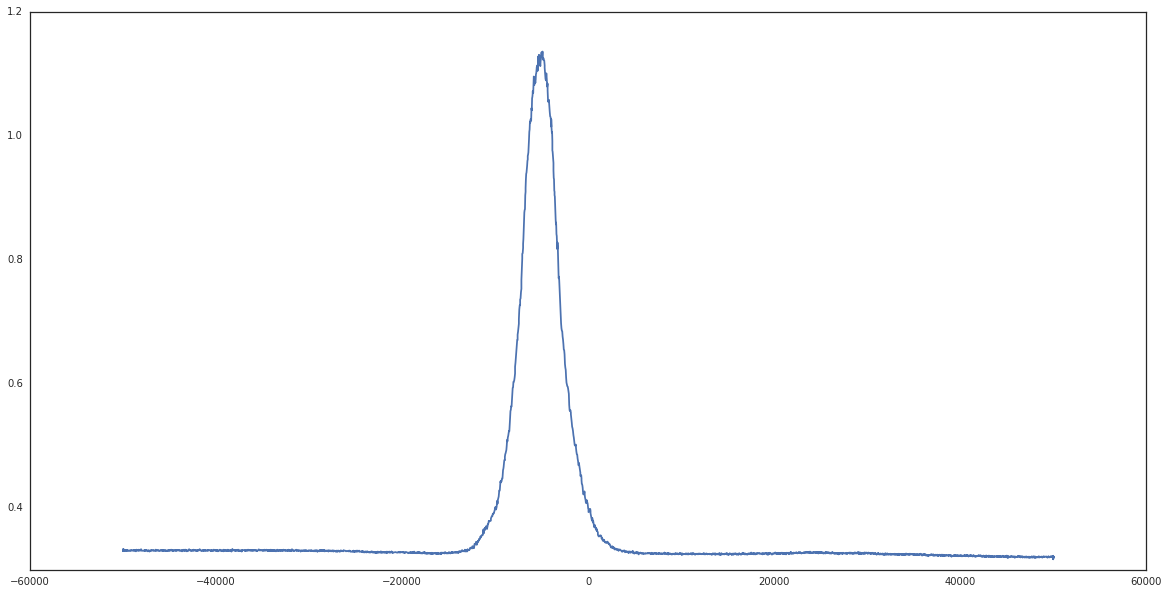

In [10]:
# plot for visual inspection of the WS profile. Sometimes issues can be picked up by looking at the distribution

i=0

sns.set_style("white")
f = plt.figure(figsize=(20,10))

plt.plot(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
         myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])

[ 2.46527047]
2.0471244334
0.00104820572895
2.23508241745


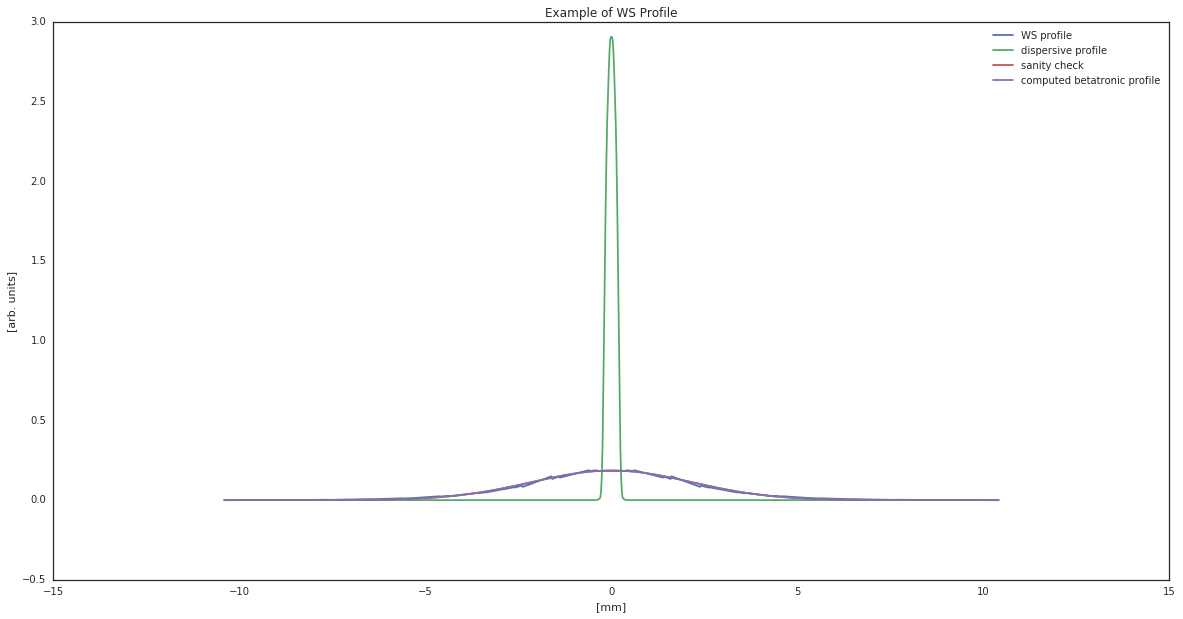

In [11]:
sns.set_style("white")

# test with the first profile
i=0
                                                   
out=gpToolbox.computeTransverseEmittance(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                         myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                         myDataFrame.iloc[i]['momentumProfile']['myProfile'],
                                         myDataFrame.iloc[i]['momentumProfile']['deltaP_P'],
                                         myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma'],
                                         betaOptical_m=modelBetaOptics_m,Dispersion_m=measuDispersion_m)

f = plt.figure(figsize=(20,10))
plt.plot(out['WS_position_mm'],out['WS_profile'],label='WS profile')
plt.hold('on')
plt.plot(out['Dispersive_position_mm'],out['Dispersive_profile'],label='dispersive profile')
plt.hold('off')
plt.xlabel('[mm]')
plt.ylabel('[arb. units]')
plt.plot(out['WS_position_mm'],out['convolutionBackComputed'],label='sanity check')
plt.plot(out['WS_position_mm'],out['betatronicProfile'],label='computed betatronic profile')
plt.legend()
#plt.xlim([-20,20])
print(out['emittance_um'])
#str(myDataFrame.iloc[i]['momentumProfile']['gamma']) +' '+ str(myDataFrame.iloc[i]['momentumProfile']['ctime']))
plt.title('Example of WS Profile')

a,b=gpToolbox.makeGaussianFit_5_parameters(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                           myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])
sigma=a[4]/1000
print(sigma)
print(myDataFrame.iloc[i]['momentumProfile']['deltaP_P_RMS'])
print (sigma**2-(myDataFrame.iloc[i]['momentumProfile']['deltaP_P_RMS']*modelDispersion_m*1000)**2)/modelBetaOptics_m*myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma']

In [12]:
def simpleMethod(myDataFrame):
    a,b=gpToolbox.makeGaussianFit_5_parameters(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                               myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])
    
    sigma=a[4]/1000
    return ((sigma**2-(myDataFrame['momentumProfile']['deltaP_P_RMS']*modelDispersion_m*1000)**2)/
            modelBetaOptics_m*myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'])



def simpleMethodMeasDisp(myDataFrame):
    a,b=gpToolbox.makeGaussianFit_5_parameters(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                               myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])
    
    sigma=a[4]/1000
    return ((sigma**2-(myDataFrame['momentumProfile']['deltaP_P_RMS']*measuDispersion_m*1000)**2)/
            modelBetaOptics_m*myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'])



def fullPower(myDataFrame):
                                                      
    out=gpToolbox.computeTransverseEmittance(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                             myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                             myDataFrame['momentumProfile']['myProfile'],
                                             myDataFrame['momentumProfile']['deltaP_P'],
                                             myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'],
                                             betaOptical_m=modelBetaOptics_m,Dispersion_m=modelDispersion_m)

    return out['emittance_um'][0]#,out['sigma_mm']


# store the emittance in the DataFrame
myDataFrame['emittance_um_old']  = myDataFrame.apply(simpleMethod,         axis=1)
myDataFrame['emittance_um_disp'] = myDataFrame.apply(simpleMethodMeasDisp, axis=1)            

if plane == 'H':
    myDataFrame['emittance_um']      = myDataFrame.apply(fullPower,            axis=1)
else:
    myDataFrame['emittance_um'] = myDataFrame['emittance_um_disp'] 


In [13]:
# uncomment for debugging
# myDataFrame.iloc[0]

In [14]:
# uncomment for debugging
#myDataFrame.loc[:,['BR_BCTDC.Acquisition.value.extIntensityRing'+ring,'emittance_um_old','emittance_um_disp','emittance_um']]

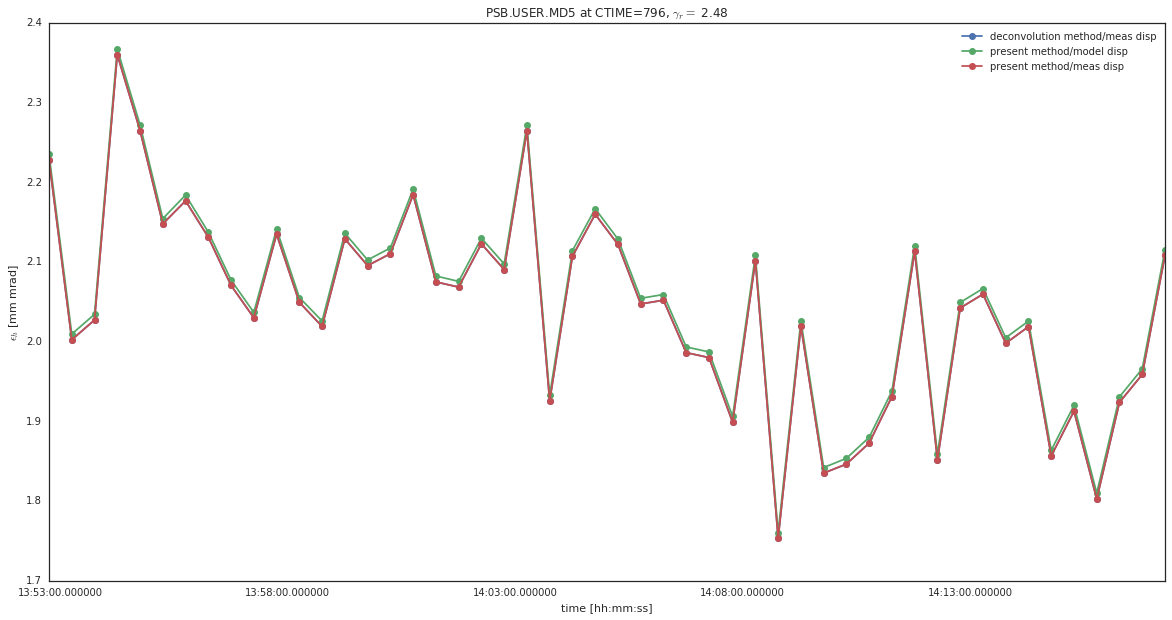

In [15]:
import matplotlib.dates as md

f = plt.figure(figsize=(20,10))

ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

plt.plot(myDataFrame['emittance_um'],'o-',label='deconvolution method/meas disp')
plt.hold('on')
plt.plot(myDataFrame['emittance_um_old'],'o-',label='present method/model disp')
plt.legend()
plt.plot(myDataFrame['emittance_um_disp'],'o-',label='present method/meas disp')
plt.legend()

#i=0
#plt.title(myDataFrame.iloc[i]['matlabPLS'] + ' at CTIME='+ str(myDataFrame.iloc[i]['momentumProfile']['ctime']) + ', $\gamma_r=$ ' + str(round(myDataFrame.iloc[i]['momentumProfile']['gamma'],2)))

plt.title(myDataFrame.iloc[i]['matlabPLS'] + ' at CTIME=796' + ', $\gamma_r=$ ' + str(round(myDataFrame.iloc[i]['momentumProfile']['gamma'],2)))
plt.ylabel('$\epsilon_h$ [mm mrad]')
plt.xlabel('time [hh:mm:ss]')

#plt.savefig('plots/WS/emittance_vs_time_r'+ring+'_p'+plane+'.png')
#plt.savefig('plots/WS/emittance_vs_time_r'+ring+'_p'+plane+'.pdf')


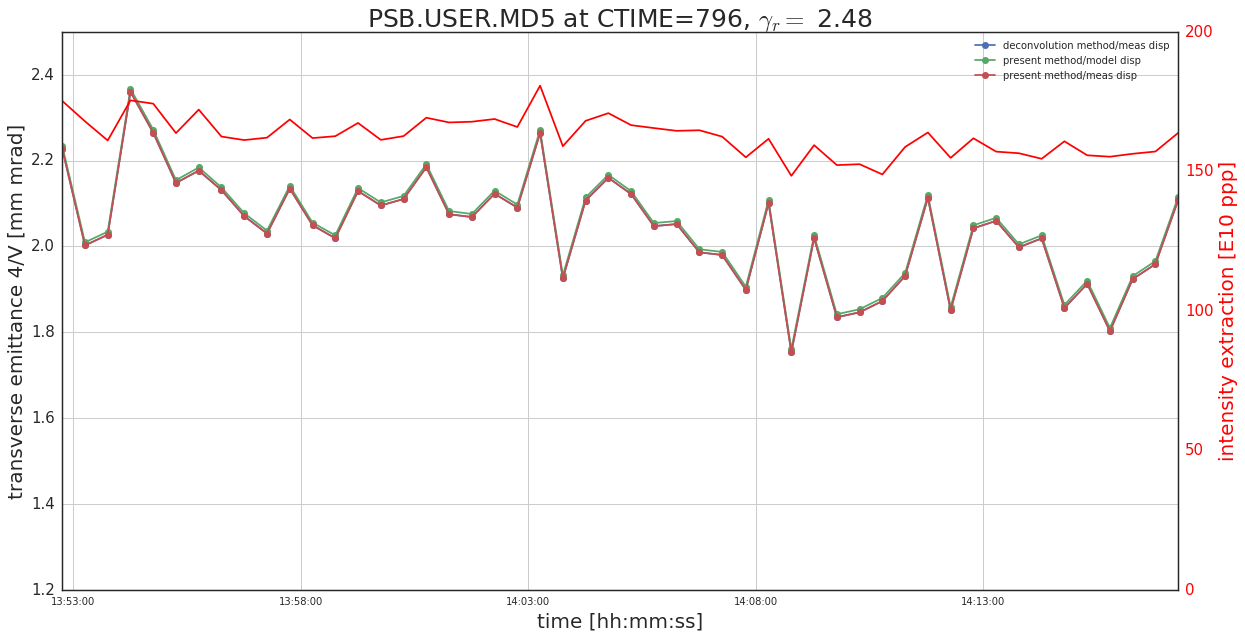

In [16]:
f = plt.figure(figsize=(20,10))

ax1 = f.add_subplot(111)
#ax1 = plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(xfmt)

ax1.plot(myDataFrame['emittance_um'],'o-',label='deconvolution method/meas disp')
ax1.hold('on')
ax1.plot(myDataFrame['emittance_um_old'],'o-',label='present method/model disp')
ax1.plot(myDataFrame['emittance_um_disp'],'o-',label='present method/meas disp')
ax1.legend()

ax1.set_title(myDataFrame.iloc[i]['matlabPLS'] + ' at CTIME=796' + ', $\gamma_r=$ ' + str(round(myDataFrame.iloc[i]['momentumProfile']['gamma'],2)),
             fontsize = 25)
ax1.set_xlabel('time [hh:mm:ss]', fontsize=20)

ax1.set_ylabel('transverse emittance '+ring+'/'+plane+' [mm mrad]', fontsize=20)
for tl in ax1.get_yticklabels():
         tl.set_fontsize(15)

ax1.set_ylim(1.2,2.5)
ax1.grid()


ax2 = ax1.twinx()
ax2.plot(myDataFrame['BR_BCTDC.Acquisition.value.extIntensityRing'+ring], 'r-')
ax2.set_ylabel('intensity extraction [E10 ppp]', color='r', fontsize=20)
for tl in ax2.get_yticklabels():
         tl.set_color('r')
         tl.set_fontsize(15)

minor_ticks = np.arange(0, 200, 10)                                               
                                                    
ax2.set_yticks(minor_ticks, minor=True) 
#ax2.grid()
#ax2.grid(which='both')
ax2.set_ylim(0,200)


f.savefig('plots/WS/emittance_vs_time_r'+ring+'_p'+plane+'.png')
f.savefig('plots/WS/emittance_vs_time_r'+ring+'_p'+plane+'.pdf')


In [17]:
# scatter plot emittance Vs intensity (@extraction)

# emitt      = myDataFrame['emittance_um'].values
# emitt_old  = myDataFrame['emittance_um_old'].values
# emitt_disp = myDataFrame['emittance_um_disp'].values

# intensity = myDataFrame['BR_BCTDC.Acquisition.value.extIntensityRing'+ring].values

# plt.plot(intensity,emitt,'bo')
# plt.hold('on')
# plt.plot(intensity,emitt_old, 'go')
# plt.plot(intensity,emitt_disp,'ro')

# import numpy

# print numpy.mean(emitt), "+/-", numpy.std(emitt)
# print numpy.mean(emitt_old), "+/-", numpy.std(emitt_old)
# print numpy.mean(emitt_disp), "+/-", numpy.std(emitt_disp)
         

In [18]:
# Attempt to check the different Dp/p distributions

# def weighted_avg_and_std(values, weights):
#     """
#     Return the weighted average and standard deviation.

#     values, weights -- Numpy ndarrays with the same shape.
#     """
#     average = numpy.average(values, weights=weights)
#     variance = numpy.average((values-average)**2, weights=weights)  # Fast and numerically precise
#     return (average, math.sqrt(variance))


def fullDeconvolution(myDataFrame):
                                                      
     out=gpToolbox.computeTransverseEmittance(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                              myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                              myDataFrame['momentumProfile']['myProfile'],
                                              myDataFrame['momentumProfile']['deltaP_P'],
                                              myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'],
                                              betaOptical_m=modelBetaOptics_m,Dispersion_m=modelDispersion_m)

     return out

if plane == 'H':    
    myDataFrame['deconv_out'] = myDataFrame.apply(fullDeconvolution, axis=1)
# #myDataFrame.iloc[0]


# #i=0
# #deconv_out = myDataFrame.iloc[i]['deconv_out']
# #plt.plot(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'],label='dispersive profile')

# for i in range(28,29):
#     print i
#     deconv_out = myDataFrame.iloc[i]['deconv_out']
#     plt.plot(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'],label='dispersive profile')
#     plt.hold('on')
#     plt.xlim([-7,7])
#     print weighted_avg_and_std(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'])
    
#     a,b=gpToolbox.makeGaussianFit_5_parameters(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'])

#     xfine = np.linspace(-7., 7., 1000)  # define values to plot the function for
#     plt.plot(xfine, gpToolbox.Gaussian_5_parameters(xfine, a[0],a[1],a[2],a[3],a[4]))

#     print a[4]


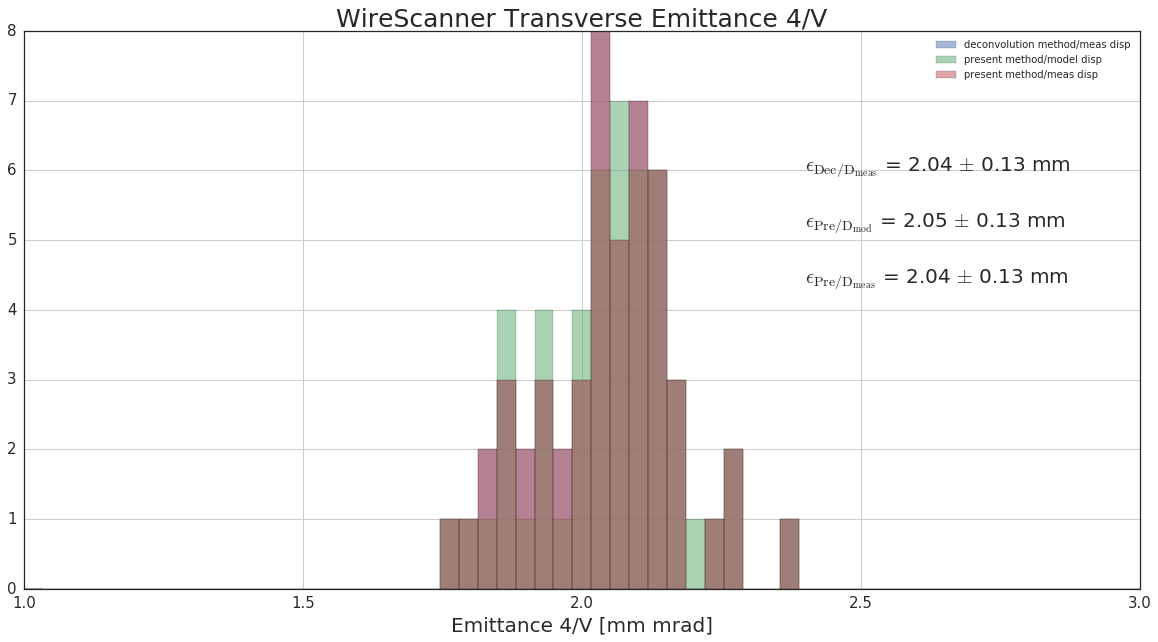

In [19]:
bins = np.linspace(1.0, 3.0, 60)

# just some handles
emittance_um_old  = myDataFrame['emittance_um_old'].values
emittance_um_disp = myDataFrame['emittance_um_disp'].values
emittance_um      = myDataFrame['emittance_um'].values     


f = plt.figure(figsize=(20,10))
ax = f.add_subplot(111)

ax.hist( emittance_um,      bins, alpha=0.5, label='deconvolution method/meas disp') 
ax.hold('on')
ax.hist( emittance_um_old,  bins, alpha=0.5, label='present method/model disp') 
ax.hist( emittance_um_disp, bins, alpha=0.5, label='present method/meas disp') 

ax.set_xlabel('Emittance '+ring+'/'+plane+' [mm mrad]', fontsize=20)
for tl in ax.get_xticklabels():
         tl.set_fontsize(15)
for tl in ax.get_yticklabels():
         tl.set_fontsize(15)


ax.set_title('WireScanner Transverse Emittance '+ring+"/"+plane, fontsize=25)

e_avg = np.mean(emittance_um)
e_std = np.std (emittance_um)

eold_avg = np.mean(emittance_um_old)
eold_std = np.std (emittance_um_old)

edisp_avg = np.mean(emittance_um_disp)
edisp_std = np.std (emittance_um_disp)

ax.annotate('$\mathrm{\epsilon_{Dec/D_{meas}}}$' + ' = {0:0.2f} $\pm$ {1:0.2f} mm'.format(e_avg, e_std), 
             (0.7, 0.75), textcoords='axes fraction', xycoords='axes fraction', size=20)
ax.annotate('$\mathrm{\epsilon_{Pre/D_{mod}}}$' + ' = {0:0.2f} $\pm$ {1:0.2f} mm'.format(eold_avg, eold_std), 
             (0.7, 0.65), textcoords='axes fraction', xycoords='axes fraction', size=20)
ax.annotate('$\mathrm{\epsilon_{Pre/D_{meas}}}$' + ' = {0:0.2f} $\pm$ {1:0.2f} mm'.format(edisp_avg, edisp_std), 
             (0.7, 0.55), textcoords='axes fraction', xycoords='axes fraction', size=20)

ax.legend()
ax.grid()
ax.hold('off')

f.savefig('plots/WS/emittance_dist_r'+ring+'_p'+plane+'.pdf')
f.savefig('plots/WS/emittance_dist_r'+ring+'_p'+plane+'.png')

In [20]:
# bins = numpy.linspace(0.98, 1.20, 22)

# ratio_um      = myDataFrame['emittance_um'].values     /myDataFrame['emittance_um_old'].values
# ratio_um_disp = myDataFrame['emittance_um_disp'].values/myDataFrame['emittance_um_old'].values

# plt.hist( ratio_um,      bins, facecolor='green', alpha=0.5) 
# plt.hist( ratio_um_disp, bins, facecolor='red'  , alpha=0.5) 

# print numpy.mean(ratio_um),      "+/-", numpy.std(ratio_um)
# print numpy.mean(ratio_um_disp), "+/-", numpy.std(ratio_um_disp)

         

In [21]:
# w_results = []

# for i in range(len(myDataFrame)):
#     #print i
#     deconv_out = myDataFrame.iloc[i]['deconv_out']
#     w_results.append( (weighted_avg_and_std(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile']))[1] )
    
# plt.plot(w_results, ratio_um, 'bo')

In [22]:
if saveData:
    myDataFrame.to_pickle('pickles/WS/dataframe_WS_r' + ring + "_p" + plane)

In [23]:
print 'Done!'

Done!
